In [1]:
%matplotlib inline

import numpy as np
from numpy.fft import fftshift, ifftshift

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

import menpo.io as mio
from menpo.image import Image
from menpo.feature import hog, no_op
from menpo.shape import PointCloud
from menpo.visualize import visualize_images

from alabortcvpr2015.correlationfilter import (
    learn_mosse, learn_mccf, learn_deep_cf)
from alabortcvpr2015.correlationfilter.utils import (
    build_grid, normalizenorm_vec, fast2dconv, crop, pad, fft2, ifft2)

In [2]:
def greyscale(i):
    return i.as_greyscale('average')

def greyscale_hog(i):
    return hog(greyscale(i))

def combine(i):
    return Image(np.concatenate((i.pixels, greyscale(i).pixels, greyscale_hog(i).pixels)))

# Correlation Filters

## Load and manipulate data

Load landmarked facial images.

In [3]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/trainset/*', verbose=True, 
                           max_images=1):
    if i.n_channels == 3:
        i.crop_to_landmarks_proportion_inplace(0.5)
        i = i.rescale_landmarks_to_diagonal_range(100)
        images.append(i)

- Loading 1 assets: [====================] 100%

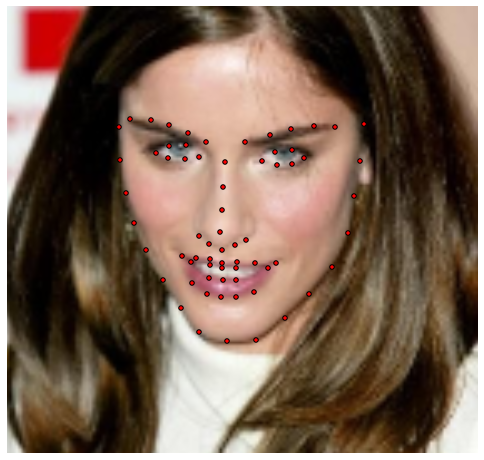

In [4]:
visualize_images(images)

Extract 31 x 31 patches around landmark number 45 (the corner of the left eye) from the previous images. Note that any other landmark could be chosen.

In [95]:
patch_shape = np.asarray((91, 91))
lm_number = 45
features = greyscale # no_op, gresycale, greyscale_hog

image_patches = []
pixel_patches = []
for i in images:
    image_patches.append(i.extract_patches_around_landmarks(patch_size=patch_shape)[lm_number])
    feature_patches = features(image_patches[-1])
    pixel_patches.append(feature_patches.pixels)

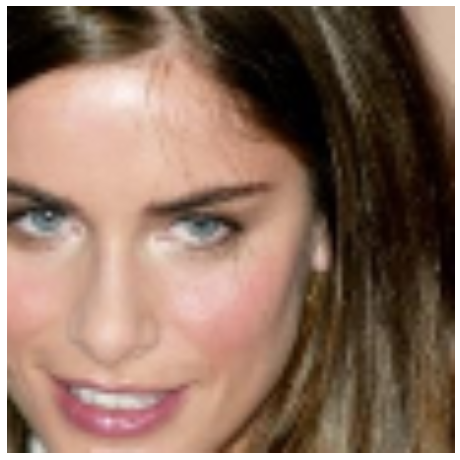

In [96]:
visualize_images(image_patches)

Store patches as numpy array.

In [97]:
X = np.asarray(pixel_patches)

These are the patches that we will used in order to define and test our Kernelized Correlation Filters. 

Define the desired response for each patch. Note that, because all patches are centred about the same landmark they share the same desired response, i.e. a 2 dimensional Gaussian response centred at the middle of the patch.

In [98]:
cov = 3

# define Gaussian response
mvn = multivariate_normal(mean=np.zeros(2), cov=cov)
grid = build_grid((31, 31))
y = mvn.pdf(grid)[None]

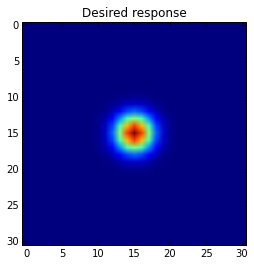

In [99]:
plt.title('Desired response')
plt.imshow(y[0])

## Learn Correlation Filter (CF)

At this point we will use the first image patch as the template from which to learn a CF. Note that we could have chosen any other image patch.

In [100]:
# img_number = 0
# x = X[img_number]

Apart from the kernel correlation specific parameters, we need to make some choices regarding the overall learning procedure.

In [101]:
# whether to normalize the image
normalize = True
# wheter to mask the images with a cosine mask
mask = True
# regularization parameter
l = 0.0
# type of filter
filter_type = 'mosse'
# boundary padding
boundary = 'constant'

c1 = np.hanning(patch_shape[0])
c2 = np.hanning(patch_shape[1])
cosine_mask = c1[..., None].dot(c2[None, ...]) if mask else None

In [102]:
X_ = np.empty_like(X)
for j, x in enumerate(X):
    x_ = normalizenorm_vec(x) if normalize else x
    x_ = cosine_mask * x_ if mask else x_
    X_[j] = x_

if filter_type is 'mosse':
    cf, _, _ = learn_mosse(X_, y, l=l, boundary=boundary)
elif filter_type is 'mccf':
    cf, _, _ = learn_mccf(X_, y, l=l, boundary=boundary)
elif filter_type is 'deep_mosse':
    cf, _, _ = learn_deep_cf(X_, y, learn_cf=learn_mosse, n_levels=1, l=l, boundary=boundary)
elif filter_type is 'deep_mccf':
    cf, _, _ = learn_deep_cf(X_, y, learn_cf=learn_mccf, n_levels=3, l=l, boundary=boundary)
# elif filter_type is 'zamosse':
#     cf = learn_zamosse(X_, y, l=l, boundary=boundary, crop_filter=True)

    
cf = cf

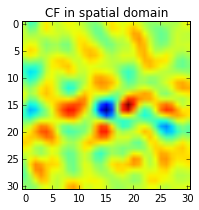

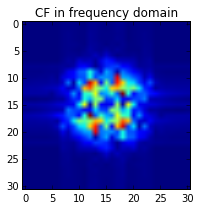

In [103]:
# only the up to the first 5 channels are shown
n_channels = np.minimum(5, cf.shape[0])
fig_size = (3*n_channels, 3*n_channels)

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, c in enumerate(cf[:n_channels]):
    plt.subplot(1, n_channels, j+1)
    plt.title('CF in spatial domain')
    plt.imshow(cf[j])

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, c in enumerate(cf[:n_channels]):
    plt.subplot(1, n_channels, j+1)
    plt.title('CF in frequency domain')
    plt.imshow(np.abs(fftshift(fft2(cf[j]))))

In [113]:
def prox(h, shape):
    #plt.imshow(np.abs(h[0])), plt.show()
    h = np.real(ifft2(h))
    #plt.imshow(h[0]), plt.show()
    h = zero_tail(h, shape)
    #plt.imshow(h[0]), plt.show()
    h = fft2(h)
    #plt.imshow(np.abs(h[0])), plt.show()
    return h


def zero_tail(h, shape):
    ext_shape = h.shape[-2:]
    h = crop(h, shape)
    return pad(h, ext_shape)



def cost_function(h, T, p):
    h_conj = h.conj()
    return np.real(np.sum(h * T * h_conj - 2 * h * p))


def true_cost_function(h, X, y):
    cost = 0
    for x in X:
        cost += np.sum((y -  np.sum(crop(fast2dconv(x, h), y_shape), axis=0)[None])**2)
    return cost


def line_search(nabla, w, T, p, shape):
    nabla = prox(nabla, shape)
    nabla_conj = nabla.conj()
    num1 = nabla * T * w
    #plt.imshow(np.abs(fftshift(num1[0]))), plt.show()
    num1 = np.sum(num1)
    num2 = nabla * p
    #plt.imshow(np.abs(fftshift(num2[0]))), plt.show()
    num2 = np.sum(num2)
    den = nabla * T * nabla_conj
    #plt.imshow(np.abs(fftshift(den[0]))), plt.show()
    den = np.sum(den)
    return np.real((num1 - num2) / den)


def backtracking(n, nu, h, T, p, nabla, y_shape):
    
    cost = cost_function(h, T, p)

    stop = False;
    while not stop:
        nh = prox(h - n * nabla, y_shape)
        diff = h - nh
        ncost = cost_function(nh, T, p)

        lin_term = np.real(np.sum(nabla * diff))
        quad_term = np.real((n / 2) * np.sum(diff.conj() * diff))

#         print 'ncost:', ncost
# #         print 'lin cost:', cost + lin_term + quad_term
#         print 'cost:', cost
# #         print 'lin term:', lin_term
# #         print 'quad cost:', quad_term
#         print '\n'
        
        if ncost > cost - lin_term + quad_term:
            n *= nu
#             print 'hello'
        else:
            stop = True
    
    return n

In [114]:
import scipy

# filter
h_ = crop(h, y_shape)
n = np.prod(h.shape)

# fourier cost function
print np.sum((fft2(y) - fft2(X[0]) / n**0.5 * fft2(h_) / n**0.5)**2) 

             
print np.sum((y -  convolve2d(X[0, 0], h_[0], mode='same')**2))

ValueError: operands could not be broadcast together with shapes (1,91,91) (1,31,31) 

In [110]:
from scipy.signal import convolve2d

In [120]:
X = X_ 
y = y 
l = 0.0
boundary = 'constant'
crop_filter = True
max_iters = 10
nu = 0.25
eps = 10**-5

# learn mosse filter
h, p, T = learn_mosse(X, y, l=l, boundary=boundary, crop_filter=False)
T += l
y_shape = y.shape[-2:]


# initialize v and w
k = 0
t = 1
err = np.inf
v = prox(fft2(h), y_shape)
w = v

cost = cost_function(v, T, p)
true_cost = true_cost_function(ifft2(v), X, y)

print 'Cost:', cost
print 'True cost:', true_cost


vs = [v]
costs = [cost]

while k < max_iters and err > eps:
    
    nabla = T * w.conj() - p
    #nabla = prox(nabla, y_shape)
    
    # line search
    n = line_search(nabla, w, T, p, y_shape)
    n = backtracking(n, nu, w, T, p, nabla, y_shape)
    
    #plt.imshow(np.abs(n)[0]), plt.show()

    # proximal gradient step
    nv = prox(w - n * nabla, y_shape)
    nt = 0.5 * (1 + np.sqrt(1 + 4 * t**2)) 
    nw = nv + ((t - 1) / nt) * (nv - v)
    
    ncost = cost_function(nv, T, p)
    ntrue_cost = true_cost_function(ifft2(nv), X, y)

    print 'Cost:', ncost
    print 'True cost:', ntrue_cost
#     print 'Cost:', np.abs(cost - ncost) / np.abs(cost)
#     print 'Err:', np.linalg.norm(v - nv) / np.linalg.norm(v)
    
    v = nv
    t = nt
    w = nw
    cost = ncost

    vs.append(v)
    costs.append(cost)
    
    # test convergence
    err = 10
    # increase iteration counter
    k += 1

v = np.real(ifft2(v))

if crop_filter:
    # crop mosse filter to match desired response shape
    v = crop(v, y_shape)
    
cf = v

Cost: 578.997776706
True cost: 0.0169450421089
Cost: 554.852394584
True cost: 0.0173152456729
Cost: 546.51434395
True cost: 0.0179209035724
Cost: 545.881658981
True cost: 0.0181329767567
Cost: 545.841915859
True cost: 0.0182306937544
Cost: 545.878610883
True cost: 0.018283982646
Cost: 545.919776152
True cost: 0.0183163540853
Cost: 545.954180849
True cost: 0.0183375462907
Cost: 545.981351912
True cost: 0.0183522037986
Cost: 546.002641636
True cost: 0.018362777867
Cost: 546.01943281
True cost: 0.0183706648315


In [121]:
aux = fft2(x)
aux2 = np.real(ifft2(aux))

print np.real(np.sum(aux.conj() * aux))
print aux2.ravel().dot(aux2.ravel())
print x.ravel().dot(x.ravel())

17853932.6242
2156.01166818
2156.01166818


We are now ready to learn a CF for the first image patch.

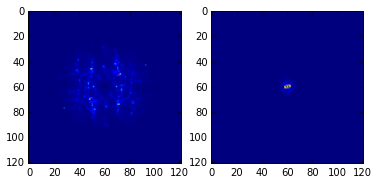

In [122]:
aux = fftshift(fft2(h))
aux2 = fftshift(T)

plt.subplot(1, 2, 1)
plt.imshow(np.abs(aux[0]))

plt.subplot(1, 2, 2)
plt.imshow(np.abs(aux2[0]))

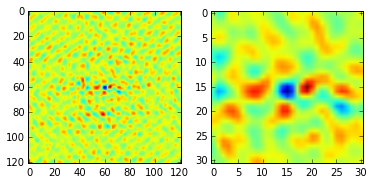

In [123]:
h2 = zero_tail(h, y_shape)

plt.subplot(1, 2, 1)
plt.imshow(h[0])
plt.subplot(1, 2, 2)
plt.imshow(cf[0])

In [124]:
rs = []
r2s = []
for z in X_:
    z_ = normalizenorm_vec(z) if normalize else z
    cf_ = normalizenorm_vec(cf) if normalize else cf
    # compute correlation response
    r = np.sum(fast2dconv(z_, h, boundary=boundary), axis=0)[None]
    r2 = np.sum(fast2dconv(z_, cf, boundary=boundary), axis=0)[None]
    rs.append(r)
    r2s.append(r2)

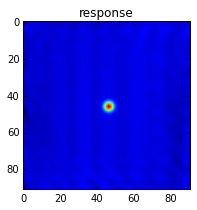

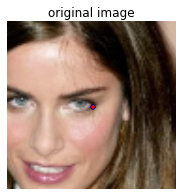

In [125]:
# only up to the first 5 images are shown
n_images = np.minimum(5, len(X_))
fig_size = (3*n_images, 3*n_images)

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, r in enumerate(rs[:n_images]):
    plt.subplot(1, n_images, j+1)
    plt.title('response')
    plt.imshow(r[0])

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, (r, i) in enumerate(zip(rs[:n_images], image_patches[:n_images])):
    plt.subplot(1, n_images, j+1)
    plt.title('original image')
    peak = np.asarray(np.unravel_index(r.argmax(), r.shape))[1:]
    i.landmarks['peak'] = PointCloud(peak[None, ...])
    i.view_landmarks(marker_face_colour='r', figure_size=fig_size)
    


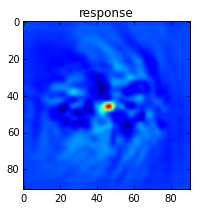

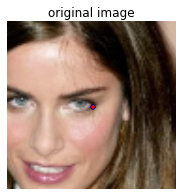

In [126]:
# only up to the first 5 images are shown
n_images = np.minimum(5, len(X_))
fig_size = (3*n_images, 3*n_images)

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, r in enumerate(r2s[:n_images]):
    plt.subplot(1, n_images, j+1)
    plt.title('response')
    plt.imshow(r[0])

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, (r, i) in enumerate(zip(r2s[:n_images], image_patches[:n_images])):
    plt.subplot(1, n_images, j+1)
    plt.title('original image')
    peak = np.asarray(np.unravel_index(r.argmax(), r.shape))[1:]
    i.landmarks['peak'] = PointCloud(peak[None, ...])
    i.view_landmarks(marker_face_colour='r', figure_size=fig_size)

## Test KCF

In order to test the correctness of the learned KCF we will extract 61 x 61 patches centred around landmark number 31, i.e the right corner of the nose. Note that we will now expect to get responses whith peaks shifted towards the right hence, correctly localizing the eye corner for which the KCF was learned.

In [ ]:
lm_test = 42

patch_shape2 =(81, 81)

image_prime_patches = []
pixel_prime_patches = []
for i in images:
    image_prime_patches.append(i.extract_patches_around_landmarks(patch_size=patch_shape2)[lm_test])
    feature_prime_patches = features(image_prime_patches[-1])
    pixel_prime_patches.append(feature_prime_patches.pixels)

In [ ]:
visualize_images(image_prime_patches)

Store patches as numpy array.

In [ ]:
X_prime = np.asarray(pixel_prime_patches)

In [ ]:
rs = []
r2s = []
for z in X_prime:
    z_ = normalizenorm_vec(z) if normalize else z
    cf_ = normalizenorm_vec(cf) if normalize else cf
    # compute correlation response
    r = np.sum(fast2dconv(z_, h, boundary=boundary), axis=0)[None]
    r2 = np.sum(fast2dconv(z_, cf, boundary=boundary), axis=0)[None]
    rs.append(r)
    r2s.append(r2)

In [ ]:
# only up to the first 5 images are shown
n_images = np.minimum(5, len(X_prime))
fig_size = (3*n_images, 3*n_images)

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, r in enumerate(rs[:n_images]):
    plt.subplot(1, n_images, j+1)
    plt.title('response')
    plt.imshow(r[0])

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, (r, i) in enumerate(zip(rs[:n_images], image_prime_patches[:n_images])):
    plt.subplot(1, n_images, j+1)
    plt.title('original image')
    peak = np.asarray(np.unravel_index(r.argmax(), r.shape))[1:]
    i.landmarks['peak'] = PointCloud(peak[None, ...])
    i.view_landmarks(marker_face_colour='r', figure_size=fig_size)

In [ ]:
# only up to the first 5 images are shown
n_images = np.minimum(5, len(X_prime))
fig_size = (3*n_images, 3*n_images)

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, r in enumerate(r2s[:n_images]):
    plt.subplot(1, n_images, j+1)
    plt.title('response')
    plt.imshow(r[0])

fig = plt.figure()
fig.set_size_inches(fig_size)
for j, (r, i) in enumerate(zip(r2s[:n_images], image_prime_patches[:n_images])):
    plt.subplot(1, n_images, j+1)
    plt.title('original image')
    peak = np.asarray(np.unravel_index(r.argmax(), r.shape))[1:]
    i.landmarks['peak'] = PointCloud(peak[None, ...])
    i.view_landmarks(marker_face_colour='r', figure_size=fig_size)